### libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LassoCV
from yellowbrick.regressor import AlphaSelection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from yellowbrick.regressor import PredictionError
import matplotlib.pyplot as plt

### Train/Test dataset

In [2]:
anime_train = pd.read_csv("data/CleanedData.csv")
anime_test = pd.read_csv("data/testDataset.csv")

In [3]:
anime_train['genre'].fillna('',  inplace=True)
anime_train['overview'].fillna('',  inplace=True)
anime_train['type'].fillna('',  inplace=True)


anime_test['genre'].fillna('',  inplace=True)
anime_test['overview'].fillna('',  inplace=True)
anime_test['type'].fillna('',  inplace=True)

### Transformation

In [4]:
import nltk
def get_words(x):
    bagofwords=[]
    for i in x:
        if i[1]=='NN':
            bagofwords.append(i[0])
        elif i[1]=='NNS':
            bagofwords.append(i[0])
        elif i[1]=='NNP':
            bagofwords.append(i[0])
        elif i[1]=='NNPS':
            bagofwords.append(i[0])
        elif i[1]=='JJ':
            bagofwords.append(i[0])
        elif i[1]=='JJR':
            bagofwords.append(i[0])
        elif i[1]=='JJS':
            bagofwords.append(i[0])
        elif i[1]=='RB':
            bagofwords.append(i[0])
        elif i[1]=='RBR':
            bagofwords.append(i[0])
        elif i[1]=='RBS':
            bagofwords.append(i[0])
    return bagofwords

def clean_words(x):
    b=nltk.pos_tag(nltk.word_tokenize(x))
    result=get_words(b)
    return result

In [5]:
def get_dummies(train_data_set, test_data_set):
    train_dummies = train_data_set.genre.str.get_dummies(',')
    test_dummies = test_data_set.genre.str.get_dummies(',')
    
    #### ALİGN
    train_dummies, test_dummies = train_dummies.align(test_dummies, axis=1, join='inner')
    
    #reset index
    train_dummies= train_dummies.reset_index()
    test_dummies = test_dummies.reset_index()
    
    train_data_set=train_data_set.reset_index()
    test_data_set=test_data_set.reset_index()
    
    train_data_set = pd.concat([train_data_set, train_dummies ], axis=1)
    test_data_set = pd.concat([test_data_set, test_dummies],  axis=1)
    
    #print("Train with genre",train_data_set.shape)    
    #print("Test with genre",test_data_set.shape)
    
    #test_dummies.fillna(0, inplace=True)
    
    type_lb = LabelBinarizer()
    fitted_type_lb = type_lb.fit(train_data_set.type.values)
    X_train = type_lb.transform(train_data_set.type.values)
    X_test  = type_lb.transform(test_data_set.type.values)
    
    dfOneHot_train = pd.DataFrame(X_train, columns = ["movie/TVseries"])
    dfOneHot_test  = pd.DataFrame(X_test,  columns = ["movie/TVseries"])
    
    dfOneHot_train.reset_index()
    dfOneHot_train.reset_index()
    
    #dfOneHot_train = pd.DataFrame(X_train, columns = ["movie/TVseries" for i in range(X_train.shape[1])])
    #dfOneHot_test  = pd.DataFrame(X_test,  columns = ["movie/TVseries" for i in range(X_test.shape[1])])
    
    #print("dfOneHot_train",dfOneHot_train.shape)    
    #print("dfOneHot_test",dfOneHot_test.shape)
    
    #train_data_set = pd.concat([train_data_set, dfOneHot_train], axis=1, join="outer")
    #train_data_set = pd.concat([train_data_set, train_dummies ], axis=1, join="inner")
    train_data_set['movie/TVseries'] = dfOneHot_train
    test_data_set['movie/TVseries'] = dfOneHot_test
    #test_data_set = pd.concat([test_data_set, dfOneHot_test], axis=1, join="outer")
    #test_data_set = pd.concat([test_data_set, test_dummies],  axis=1,  join="inner")
    
    #test_data_set['movie/TVseries'].fillna(0, inplace=True)
    #train_data_set['movie/TVseries'].fillna(0, inplace=True)
    #print("Train with genre and type",train_data_set.shape)    
    #print("Test with genre and type",test_data_set.shape)
    
    
    #null_columns = train_data_set.columns[train_data_set.isnull().any()]
    #print(train_data_set[null_columns].isnull().sum())


    #null_columns = test_data_set.columns[test_data_set.isnull().any()]
    #print(test_data_set[null_columns].isnull().sum())

    return ([train_data_set, test_data_set])

def feature_transformation(train_data_set, test_data_set):
    
    dummieset = get_dummies(train_data_set, test_data_set)
    train_data_set = dummieset[0]
    test_data_set = dummieset[1]
        
    #Bag of Words
    summary_doc_train = train_data_set['overview'].fillna("").map(clean_words)
    summary_doc_train =summary_doc_train.apply(','.join)
    
    summary_doc_test = test_data_set['overview'].fillna("").map(clean_words)
    summary_doc_test =summary_doc_test.apply(','.join)
    
    print("overview",summary_doc_train.shape)    
    print("overview",summary_doc_test.shape)
 
    vectorizer = TfidfVectorizer()
    fitted_vectorizer = vectorizer.fit(summary_doc_train)
    overview_feature_train = fitted_vectorizer.transform(summary_doc_train).toarray()
    overview_feature_test = fitted_vectorizer.transform(summary_doc_test).toarray()
    
    df_train = pd.DataFrame(overview_feature_train, columns = ["word"+ str(int(i)) for i in range(overview_feature_train.shape[1])]) 
    
    df_train= df_train.reset_index()
    train_data_set = train_data_set.reset_index()
    train_data_set = pd.concat([train_data_set, df_train], axis=1)
    print("dataset after add overview",train_data_set.shape) 
   
    df_test = pd.DataFrame(overview_feature_test, columns = ["word"+ str(int(i)) for i in range(overview_feature_test.shape[1])]) 
    df_test= df_test.reset_index()
    test_data_set = test_data_set.reset_index()
    test_data_set = pd.concat([test_data_set, df_test], axis=1)
    print("dataset after add overview test",test_data_set.shape)
    
    train_data_set = train_data_set.drop(columns=['anime_id', 'name', 'genre', 'overview', 'type'])
    test_data_set = test_data_set.drop(columns=['anime_id', 'name', 'genre', 'overview', 'type'])
    
    #drop NaN values
    #train_data_set.dropna(inplace=True)
    #test_data_set.dropna(inplace=True)
    
    #train_data_set.fillna(0, inplace=True)
    #test_data_set.fillna(0, inplace=True)
    return ([train_data_set, test_data_set])


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# generate features vector
transformed_features = feature_transformation(anime_train, anime_test)
anime_train = transformed_features[0]
anime_test = transformed_features[1]

#print(anime_train.shape)
#print(anime_test.shape)

print('train before drop \n',anime_train.shape)
print('test before drop \n',anime_test.shape)

#drop NaN values
anime_train.dropna(inplace=True)
anime_test.dropna(inplace=True)

print('train after drop \n',anime_train.shape)
print('test after drop \n',anime_test.shape)

null_columns = anime_train.columns[anime_train.isnull().any()]
print(anime_train[null_columns].isnull().sum())


null_columns = anime_test.columns[anime_test.isnull().any()]
print(anime_test[null_columns].isnull().sum())



overview (467,)
overview (400,)
dataset after add overview (467, 3915)
dataset after add overview test (400, 3915)
train before drop 
 (467, 3910)
test before drop 
 (400, 3910)
train after drop 
 (454, 3910)
test after drop 
 (395, 3910)
Series([], dtype: float64)
Series([], dtype: float64)


In [7]:
# split features vector 
anime_y_train = anime_train['rating']
anime_X_train = anime_train.drop(columns=['rating'])

anime_y_test = anime_test['rating']
anime_X_test = anime_test.drop(columns=['rating'])

### Feature Selection

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler

selector = SelectKBest(score_func=f_regression,k=700)
features = selector.fit(anime_X_train, anime_y_train)

# summarize scores
np.set_printoptions(precision=3)

print(anime_X_train.shape)
print(anime_X_test.shape)
anime_X_train = features.transform(anime_X_train)
anime_X_test = features.transform(anime_X_test)
print(anime_X_train.shape)
print(anime_X_test.shape)

scaler = StandardScaler() 

# Apply transform to both the training set and the test set.
anime_X_train = scaler.fit_transform(anime_X_train)  
anime_X_test = scaler.transform(anime_X_test) 

(454, 3909)
(395, 3909)
(454, 700)
(395, 700)


### Training - Testing - Evaluation

In [9]:
def training(model, dataset, label):
    clf = model
    clf.fit(dataset, label)
    return clf

def testing_evaluation(model, testset):
    # Make predictions using the testing set
    anime_y_pred = model.predict(testset)
    
    # The mean squared error
    print("Mean squared error: %.2f" % np.sqrt(mean_squared_error(anime_y_test, anime_y_pred)))
    
    visualizer = PredictionError(model)
    visualizer.fit(anime_X_train, anime_y_train)  # Fit the training data to the visualizer
    visualizer.score(anime_X_test, anime_y_test)  # Evaluate the model on the test data
    g = visualizer.poof() 
    
    plt.plot(anime_y_test, '--g', anime_y_pred, '--b')

### Training

Mean squared error: 1.05


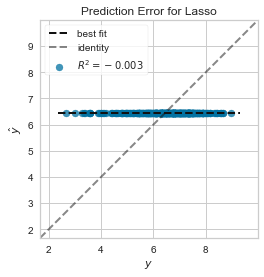

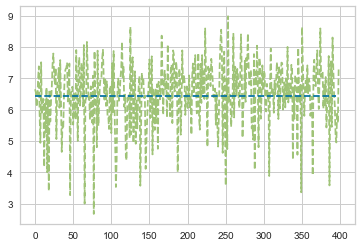

In [10]:
clf = training(model = linear_model.Lasso(), dataset = anime_X_train, label= anime_y_train)
testing_evaluation(clf, anime_X_test)

### Cross Validation

In [11]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
scores = cross_val_score(clf, anime_X_train, anime_y_train, scoring="neg_mean_squared_error", cv=5) 
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)

Scores: [1.048 0.97  1.156 0.896 0.922]
Mean: 0.9984975346757018
Standard deviation: 0.09444931766656194


### Grid Search For Hyper Parameter Selection

In [12]:
def checkHP(model, folds, dataset, label):
    parameters = {
                    "alpha" : [1,0.1,0.01,0.001,0.0001,0]
                  }

    gd_sr = GridSearchCV(estimator=model,  
                         param_grid=parameters,
                         scoring="neg_mean_squared_error",
                         cv=folds)

    gd_sr.fit(dataset, label)  
    
    best_parameters = gd_sr.best_params_  
    print("best parameters are: ", best_parameters)

    best_result = gd_sr.best_score_  
    print("The mean squared Error is: %.2f" % -best_result) 
    
checkHP(clf, 5, anime_X_train, anime_y_train) 

best parameters are:  {'alpha': 0.01}
The mean squared Error is: 0.78


c:\users\larat\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Retraining

Mean squared error: 1.14


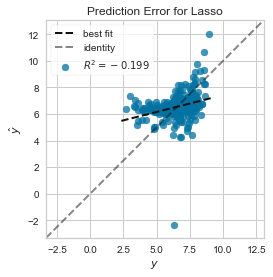

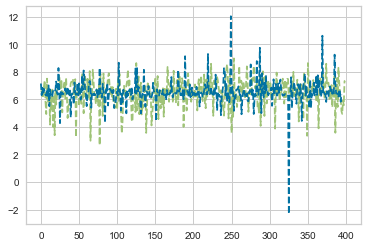

In [14]:
clf = training(model = linear_model.Lasso(alpha=0.01), dataset = anime_X_train, label= anime_y_train)
testing_evaluation(clf, anime_X_test)